In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import csv
import datetime
import gsw
import glob
import matplotlib as mpl
import matplotlib.cm as cm
#import matplotlib.colormaps as cmaps
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as inset_axes
import numpy as np
import os
import pandas as pd
import pickle
#import rasterio.plot
import scipy.io
#import seaborn as sns
import seawater
import seawater.eos80 as sw
import xarray as xr
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from shapely.geometry import LineString, MultiLineString, Point, Polygon
from shapely.ops import unary_union



mpl.style.use('seaborn-muted')
#mpl.rc('font', family ='Arial')

/tmp/ipykernel_345666/4225397793.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-muted')


In [ ]:
########################################################################################################
########################################################################################################
############################################# loading data #############################################
########################################################################################################
########################################################################################################

In [2]:
import glob

headers = []
csv_cast_lat_lon = {}
csv_ctd_data_dict = {}

# directory where the csv files are stored
csv_dir = r"/darnley/CDMeanState/Data/Final/Seal_CTD_and_Argo_type"

# can choose what files to exclude. s04i_97 has an error with oxygen readings below a certain depth, so can remove it this way
# exclude_file = "s04i_97_updated.csv"
exclude_file = "1987_bAU002712_wod_010114182O.nc_153_derivedvariables_ordered_type.csv"


for filename in glob.glob(os.path.join(csv_dir, "*.csv")):
    # can comment this line out if want all the files
    if os.path.basename(filename) != exclude_file:
        # read the csv file
        first = True
        try:
            csv_filehandle = open(filename)
            # print(filename)
            csvfile = csv.reader(csv_filehandle)
        except:
            # print("load fail")
            continue

        # get the file name without the directory path and file extension
        fn = os.path.splitext(os.path.basename(filename))[0]

        # initialize the data structure
        csv_ctd_data_dict[fn] = {}
        
        # Flag variable to check if 'time' column is found
        time_column_found = False
        
        # Flag to check if salinity < 20 is found
        low_salinity_found = False
        
        for row in csvfile:
            if first:
                header = row

                first = False
                for i in range(len(row)):
                    headers.append(row[i])
                    csv_ctd_data_dict[fn][row[i]] = []
                    
                    # Check if 'time' column exists in the header
                    if row[i] == 'time':
                        time_column_found = True

                # If 'time' column is not found, print the error and break
                if not time_column_found:
                    print(f"'time' column not found in file: {filename}")
                    break

            else:
                # Convert salinity to a float and check if it's less than 20
                salinity = float(row[2])  # Assuming salinity is at index 2
                if salinity < 20:
                    low_salinity_found = True
                    print(f"Low salinity found in file: {filename}")
                    break
                
                for i in range(len(row)):
                    csv_ctd_data_dict[fn][headers[i]].append(float(row[i]))

        csv_cast_lat_lon[fn] = {'lat': np.mean(csv_ctd_data_dict[fn]['latitude']), 'lon': np.mean(csv_ctd_data_dict[fn]['longitude'])}

# Print a message if no files with low salinity were found
if not low_salinity_found:
    print("No files with salinity < 20 were found.")

print(csv_cast_lat_lon)


No files with salinity < 20 were found.
{'2016_bAU005882_wod_017871129O.nc_325_derivedvariables_ordered_type': {'lat': -65.702, 'lon': 69.86799999999997}, '2010_bUS025289_wod_015285970O.nc_101_derivedvariables_ordered_type': {'lat': -65.981674, 'lon': 71.21315000000001}, '2017_bIN001232_wod_018153585O.nc_348_derivedvariables_ordered_type': {'lat': -65.965, 'lon': 64.149}, '2022_bAU006636_wod_021308761O.nc_684_derivedvariables_ordered_type': {'lat': -66.76154999999999, 'lon': 64.3392}, 'cnv_subset_PS128_033_01_DOWN_1m_updated_type': {'lat': -64.13699999999999, 'lon': 64.39866667000001}, '2001_bAU003608_wod_011280931O.nc_171_derivedvariables_ordered_type': {'lat': -66.33320000000002, 'lon': 64.0752}, '2022_bAU006485_wod_021968351O.nc_717_derivedvariables_ordered_type': {'lat': -65.51823000000002, 'lon': 67.99732}, '2011_bAU003979_wod_015205537O.nc_38_derivedvariables_ordered_type': {'lat': -65.86199999999997, 'lon': 69.22000000000003}, '2020_bIN001353_wod_020347777O.nc_539_derivedvariabl

In [3]:
#check it loaded all the files 
len(csv_cast_lat_lon)

1148

In [4]:
##run this code to order the dictionary by lat & lon
## i origingally did this when I had less casts and had a legend instead of a colour bar, so not really necessary, 
## but i use this dictionary in code later on so it does'nt hurt to do it or you will have to change the dictionary you call in plots below

csv_lon_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lon']))
csv_lat_ordered = sorted(csv_cast_lat_lon, key=lambda x: (csv_cast_lat_lon[x]['lat']))

In [5]:
#find the max depth (don't need this I was just curious)

max_depth = float('-inf')  # Initialize with negative infinity

# Iterate through top-level keys in the data dictionary
for dataset_key in csv_ctd_data_dict.keys():
    depth_values = csv_ctd_data_dict[dataset_key]['depth']
    max_depth_dataset = max(depth_values)
    
    # Update max_depth if the current dataset's max depth is greater
    if max_depth_dataset > max_depth:
        max_depth = max_depth_dataset

print("Maximum Depth:", max_depth)

Maximum Depth: 4184.780948


In [6]:
# Define the latitude range you want to plot
lat_min = -67
lat_max = -66.5

# Define the longitude range you want to plot
lon_min = 63
lon_max = 73

# Initialize empty lists for each variable
temperature_list = []
cons_temperature_list = []
salinity_list = []
abs_salinity_list = []
oxygen_list = []
latitude_list = []
longitude_list = []
pressure_list = []
depth_list = []
neutral_density_list = []
time_list = []
type_list = []


# Loop over the dictionary and extract the data for each variable
for cast in csv_ctd_data_dict.values():
    temperature_list.append(cast['temperature'])
    cons_temperature_list.append(cast['conservative temperature'])
    salinity_list.append(cast['salinity'])
    abs_salinity_list.append(cast['absolute salinity'])
    try:
        oxygen_list.append(cast['oxygen'])
    except KeyError:
        pass
    #oxygen_list.append(cast['oxygen'])
    latitude_list.append(cast['latitude'])
    longitude_list.append(cast['longitude'])
    pressure_list.append(cast['pressure'])
    depth_list.append(cast['depth'])
    neutral_density_list.append(cast['neutral density'])
    time_list.append(cast['time'])
    type_list.append(cast['type'])



# Convert the lists to NumPy arrays
temperature = np.concatenate(temperature_list)
cons_temperature = np.concatenate(cons_temperature_list)
salinity = np.concatenate(salinity_list)
abs_salinity = np.concatenate(abs_salinity_list)
oxygen = np.concatenate(oxygen_list)
latitude = np.concatenate(latitude_list)
longitude = np.concatenate(longitude_list)
pressure = np.concatenate(pressure_list)
depth = np.concatenate(depth_list)
neutral_density = np.concatenate(neutral_density_list)
time = np.concatenate(time_list)
type = np.concatenate(type_list)

In [ ]:
########################################################################################################
########################################################################################################
############################################### plotting ###############################################
########################################################################################################
########################################################################################################

In [7]:
# Calculate the potential density lines if needed 
sa = np.arange(33, 35, .1)
#comment out these 3 lines if you are using the neutral density contours made in matlab 
# y = np.arange(-2, 3, .2)
# X, Y = np.meshgrid(x, y)
# Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

In [8]:
##plotting the freezing point line 
#calculate the freezing point of salt water at 1 atm pressure
#sa is the salinity range of this graph calculated using arange just above 
FP0=seawater.eos80.fp(sa, 0)

In [9]:
#this is the code for neutral density contours made in matlab using the TSgamfits code from laura HB
# Load the .mat file into Python using scipy.io.loadmat()
import scipy.io
data = scipy.io.loadmat('neu_dens_contours.mat')
# Extract the x and y variables from the data dictionary
x = data['x']
y = data['y']

In [10]:
#load colour maps
cmap_temp = cmocean.cm.thermal
cmap_salt = cmocean.cm.haline
cmap_dens = cmocean.cm.dense
cmap_deep = cmocean.cm.deep
cmap_ice = cmocean.cm.ice

# #old way of getting these that got updated
#cmap_temp = plt.cm.get_cmap('cmo.thermal')
# cmap_salt = plt.cm.get_cmap('cmo.haline')
# cmap_dens = plt.cm.get_cmap('cmo.dense')
# cmap_deep = plt.cm.get_cmap('cmo.deep')


In [11]:
#split data up into argo, seal & ship so can make them different markers in plots

seals_data = type == 1
ships_data = type == 2
argo_data = type == 3

seals_latitude = latitude[seals_data]
seals_longitude = longitude[seals_data]
seals_cons_temperature = cons_temperature[seals_data]
seals_abs_salinity = abs_salinity[seals_data]
seals_depth = depth[seals_data]
seals_neutral_density = neutral_density[seals_data]
seals_time = time[seals_data]

ships_latitude = latitude[ships_data]
ships_longitude = longitude[ships_data]
ships_cons_temperature = cons_temperature[ships_data]
ships_abs_salinity = abs_salinity[ships_data]
ships_depth = depth[ships_data]
ships_neutral_density = neutral_density[ships_data]
ships_time = time[ships_data]

argo_latitude = latitude[argo_data]
argo_longitude = longitude[argo_data]
argo_cons_temperature = cons_temperature[argo_data]
argo_abs_salinity = abs_salinity[argo_data]
argo_depth = depth[argo_data]
argo_neutral_density = neutral_density[argo_data]
argo_time = time[argo_data]

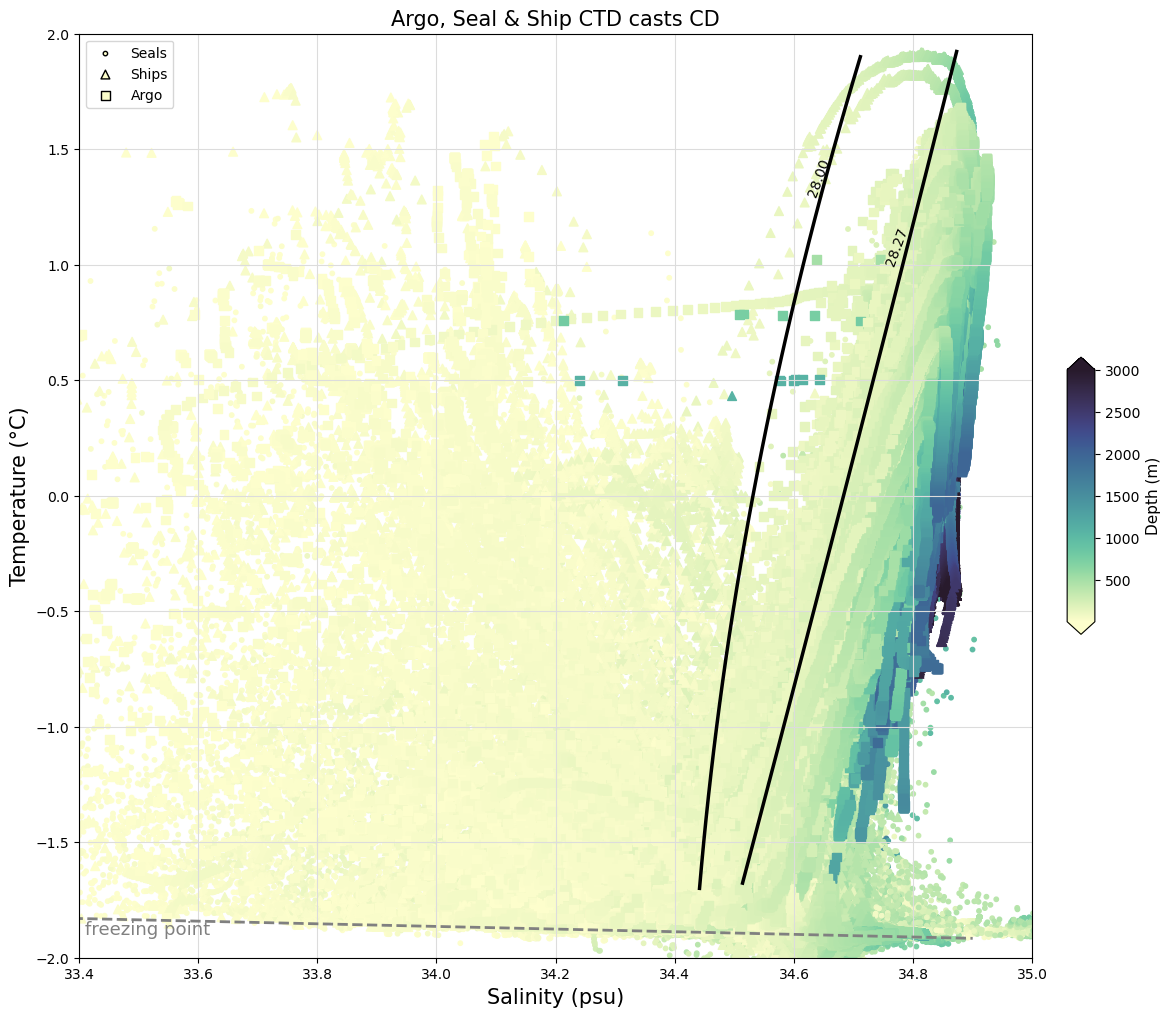

In [12]:
##TS plot

#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_depth, cmap=cmap_deep, vmax = 3000, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_depth, cmap=cmap_deep, vmax = 3000, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature,
                           s=40, c=argo_depth, cmap=cmap_deep, vmax=3000, marker='s', label='Argo')



#plot the x & y values from matlab to put on the neutral density lines    
plt.plot(x, y, 'k', linewidth = '2.5')


#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Depth (m)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')

plt.show()

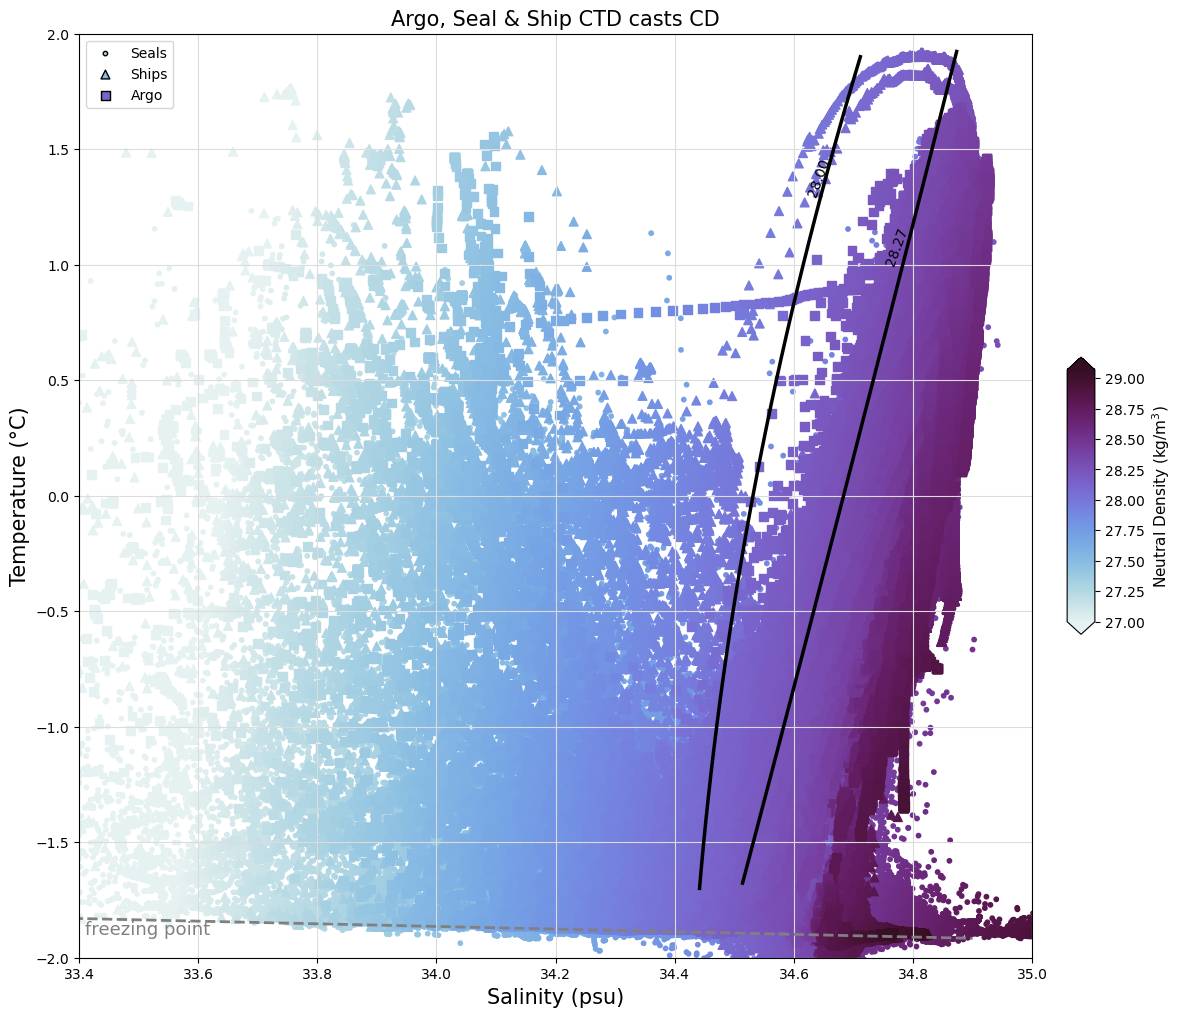

In [13]:
#set the size of the figure
plt.figure(figsize=(15, 12)) 




# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=10, c=seals_neutral_density, cmap=cmap_dens, vmin = 27, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=40, c=ships_neutral_density, cmap=cmap_dens, vmin = 27, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, s=40, c=argo_neutral_density, cmap=cmap_dens, vmin=27, marker='s', label='Argo')



#plot the x & y values from matlab to put on the neutral density lines    
plt.plot(x, y, 'k', linewidth = '2.5')


#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Salinity (psu)',  fontsize=15)
plt.ylabel('Temperature (°C)',  fontsize=15)
plt.title('Argo, Seal & Ship CTD casts CD',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')


plt.show()

/tmp/ipykernel_345666/537653037.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')


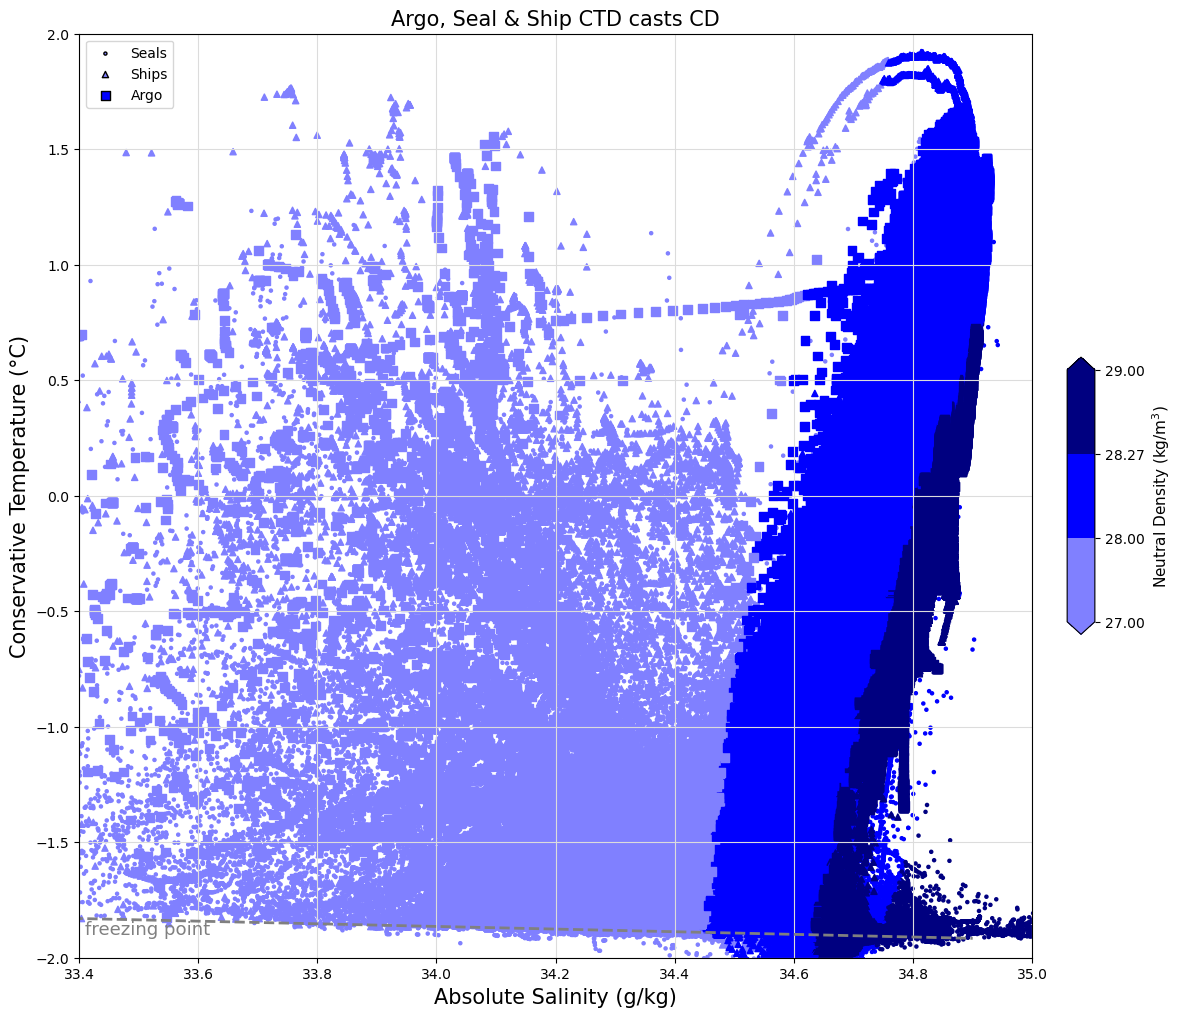

In [14]:
#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin = 27
vmax1 = 28
vmax2 = 28.27
vmax3 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin, vmax1, vmax2, vmax3], cmap_custom.N)


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, 
                           s=40, c=argo_neutral_density, cmap=cmap_custom, vmin=27.5, marker='s', label='Argo')




#plot the x & y values from matlab to put on the neutral density lines from matlab  
# plt.plot(x, y, 'k', linewidth = '2.5')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')



#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')



# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')



# Add a dynamic title
plt.title(f'Argo, Seal & Ship CTD casts CD', fontsize=15)

plt.show()

/tmp/ipykernel_345666/3477828581.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')


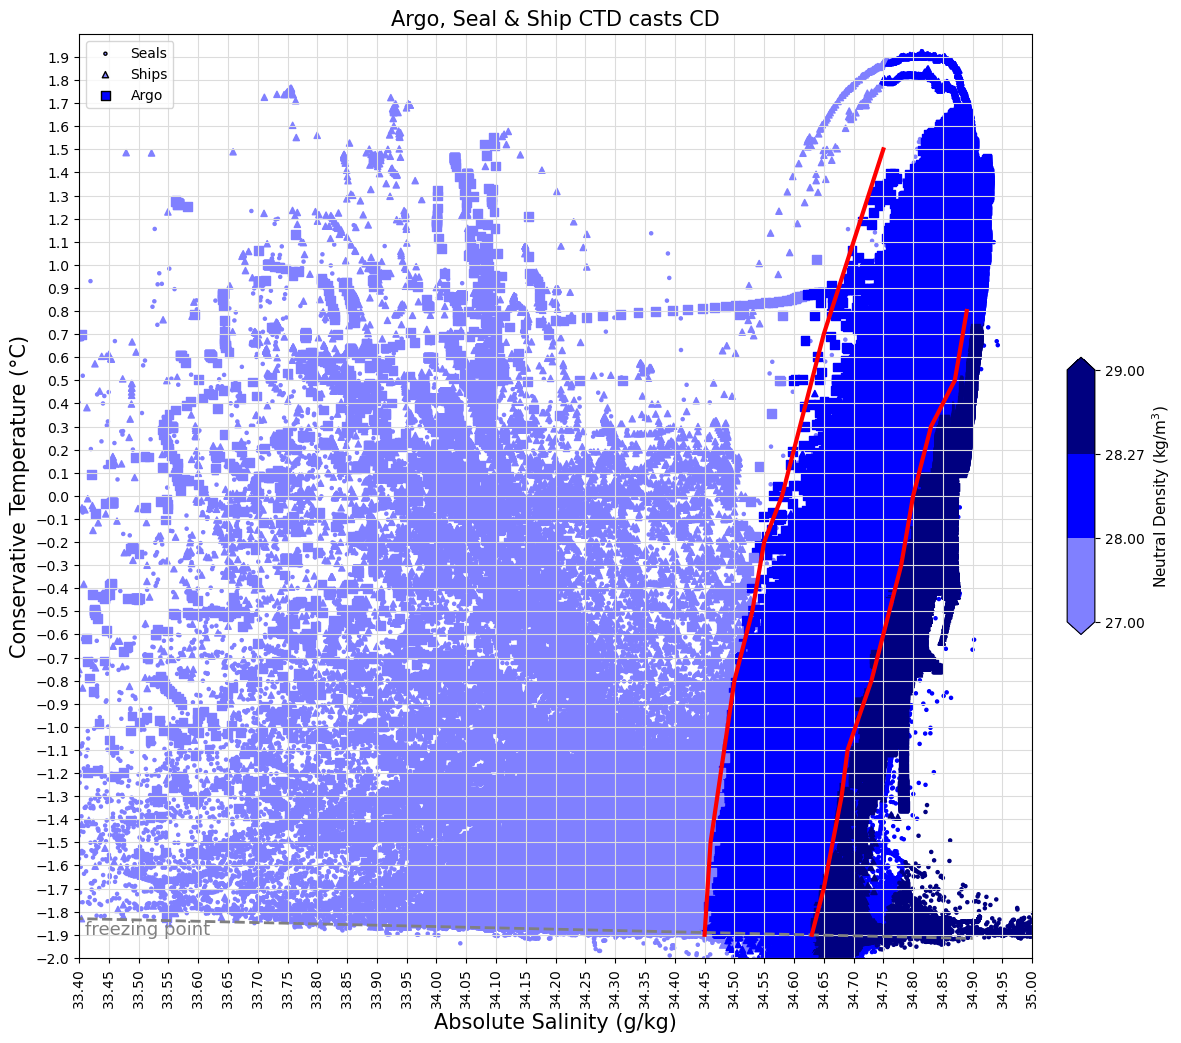

In [17]:
#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin = 27
vmax1 = 28
vmax2 = 28.27
vmax3 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin, vmax1, vmax2, vmax3], cmap_custom.N)


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, 
                           s=40, c=argo_neutral_density, cmap=cmap_custom, vmin=27.5, marker='s', label='Argo')




#plot the x & y values from matlab to put on the neutral density lines from matlab  
# plt.plot(x, y, 'k', linewidth = '2.5')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')



#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xticks(np.arange(33.4,35, 0.05), rotation=90)
plt.yticks(np.arange(-2,2, 0.1))
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')


# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')





# Define the points for your contour line 28.27 neu dense
#contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_points1 = [(34.63,-1.9), (34.65,-1.7), (34.68,-1.3), (34.69,-1.1), (34.73,-0.8), (34.75,-0.6), (34.78,-0.3), (34.8,0), (34.83, 0.3), (34.87,0.5), (34.89,0.8)]
contour_x1, contour_y1 = zip(*contour_points1)

# Plot the contour line
plt.plot(contour_x1, contour_y1, color='red', linewidth=3, label='Contour Line')






# Define the points for your contour line 28 neu dens
#contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_points2 = [(34.45,-1.9), (34.46,-1.5), (34.5,-0.8), (34.53,-0.5), (34.55,-0.2), (34.58,0), (34.6,0.2), (34.65,0.7), (34.7,1.1), (34.75,1.5)]
contour_x2, contour_y2 = zip(*contour_points2)

# Plot the contour line
plt.plot(contour_x2, contour_y2, color='red', linewidth=3, label='Contour Line')


# Add a dynamic title
plt.title(f'Argo, Seal & Ship CTD casts CD', fontsize=15)

plt.show()

/tmp/ipykernel_345666/2264268598.py:69: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')


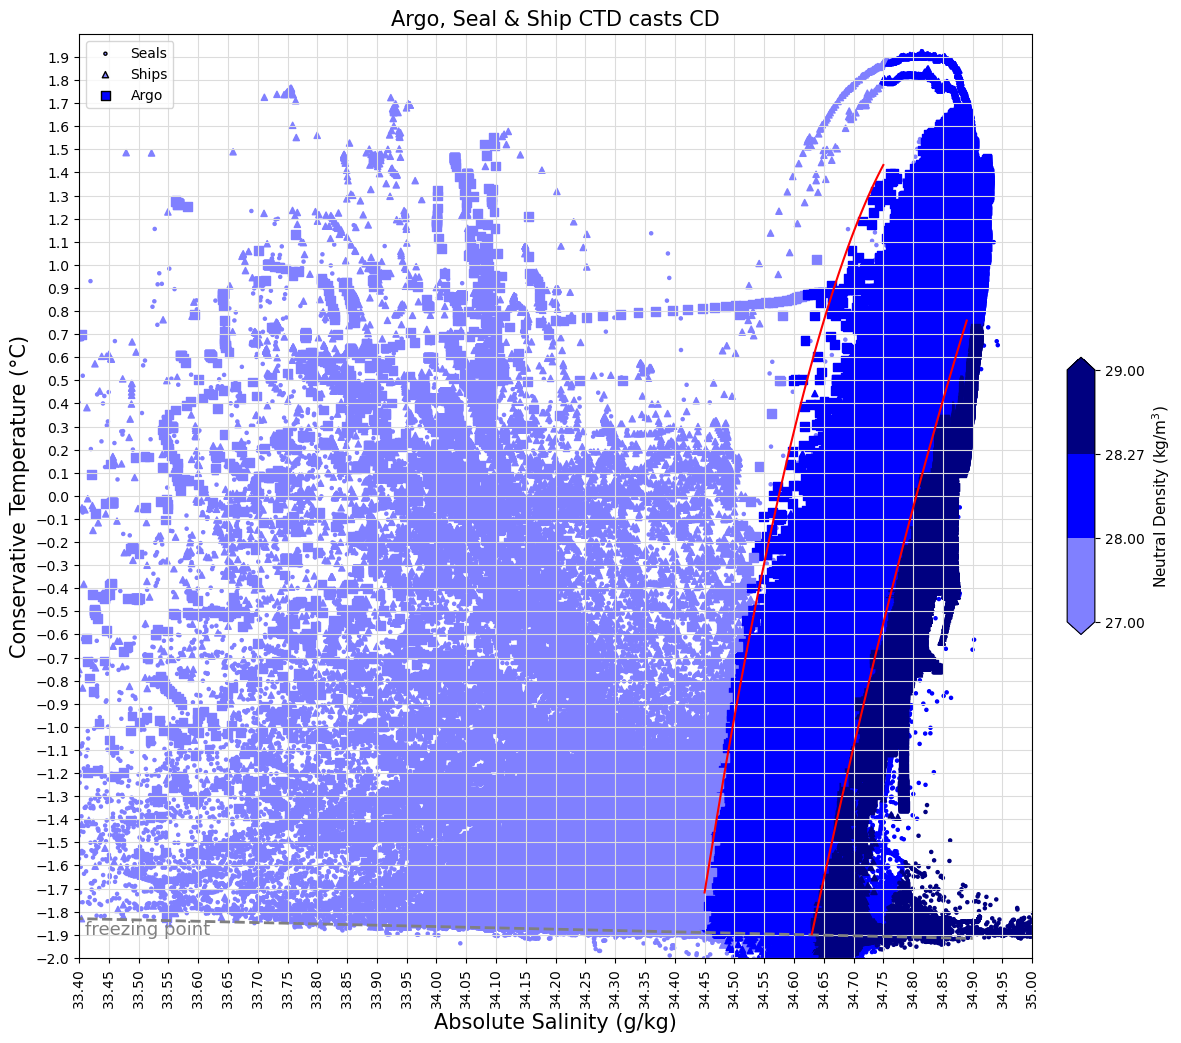

In [15]:
#set the size of the figure
plt.figure(figsize=(15, 12)) 


# Define custom color boundaries
vmin = 27
vmax1 = 28
vmax2 = 28.27
vmax3 = 29


# Define colors for different ranges
#colors = [(0.7, 0.7, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
colors = [(0.5, 0.5, 1), (0, 0, 1), (0, 0, 0.5)]  # Light blue, blue, dark blue
#colors = [(0.7, 0.7, 0.7), (0, 0, 1), (0.3, 0.3, 0.3)]  # Light blue, blue, dark blue
#cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_blue', colors, N=256)
cmap_custom = mcolors.ListedColormap(colors)

# Normalize the colormap
norm = mcolors.BoundaryNorm([vmin, vmax1, vmax2, vmax3], cmap_custom.N)


# Plot the scatter plot with temperature-based coloring and different marker shapes for seals and ships
seals_scatter = plt.scatter(seals_abs_salinity, seals_cons_temperature,
                           s=5, c=seals_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='o', label='Seals')

ships_scatter = plt.scatter(ships_abs_salinity, ships_cons_temperature,
                           s=20, c=ships_neutral_density, cmap=cmap_custom, vmin = 27.5, marker='^', label='Ships')

argo_scatter = plt.scatter(argo_abs_salinity, argo_cons_temperature, 
                           s=40, c=argo_neutral_density, cmap=cmap_custom, vmin=27.5, marker='s', label='Argo')




#plot the x & y values from matlab to put on the neutral density lines from matlab  
# plt.plot(x, y, 'k', linewidth = '2.5')

# Plot the potential density contour lines
## comment these lines out if you are doing the neutral density lines
# CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed', levels=np.arange(22,30,.05))
# plt.clabel(CS, inline=1, fontsize=10, fmt='%0.2f')


#plot salinity vs the freezing point 
plt.plot(sa, FP0, 'gray', linewidth = '2', linestyle = '--')

#put labels on the neutral density lines
# plt.text(34.75,1,'28.27', rotation=70, fontsize=10)
# plt.text(34.62,1.3,'28.00', rotation=70, fontsize=10)
#put labels on the freezing point line
plt.text(33.41,-1.9,'freezing point', fontsize=13, color = 'gray')



#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim(33.4,35)
plt.ylim(-2,2)
plt.xticks(np.arange(33.4,35, 0.05), rotation=90)
plt.yticks(np.arange(-2,2, 0.1))
plt.xlabel('Absolute Salinity (g/kg)',  fontsize=15)
plt.ylabel('Conservative Temperature (°C)',  fontsize=15)
plt.grid(color='gainsboro')


# # Add colorbar
#cbar = plt.colorbar(seals_scatter, orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
#cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_custom),orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm), orientation='vertical', shrink=0.3, pad=0.03, aspect=10, extend='both')
cbar.set_label('Neutral Density (kg/m$^3$)', fontsize=11)


# Create a legend
legend = plt.legend()

# Set the color of legend handles to black
for handle in legend.legend_handles:
    handle.set_color('black')





# Define the points for your contour line 28.27 neu dense
#contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_points1 = [(34.63,-1.9), (34.65,-1.7), (34.68,-1.3), (34.69,-1.1), (34.73,-0.8), (34.75,-0.6), (34.78,-0.3), (34.8,0), (34.83, 0.3), (34.87,0.5), (34.89,0.8)]
contour_x1, contour_y1 = zip(*contour_points1)


# Separate x and y values
x1 = [point[0] for point in contour_points1]
y1 = [point[1] for point in contour_points1]

# Fit a polynomial of degree 2 (you can change the degree as needed)
coefficients1 = np.polyfit(x1, y1, 2)
polynomial1 = np.poly1d(coefficients1)

# Generate x values for the curve
x_curve1 = np.linspace(min(x1), max(x1), 100)
y_curve1 = polynomial1(x_curve1)


plt.plot(x_curve1, y_curve1, color='red')

# Plot the contour line
#plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')






# Define the points for your contour line 28 neu dens
#contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_points2 = [(34.45,-1.9), (34.46,-1.5), (34.5,-0.8), (34.53,-0.5), (34.55,-0.2), (34.58,0), (34.6,0.2), (34.65,0.7), (34.7,1.1), (34.75,1.5)]
contour_x2, contour_y2 = zip(*contour_points2)


# Separate x and y values
x2 = [point[0] for point in contour_points2]
y2 = [point[1] for point in contour_points2]

# Fit a polynomial of degree 2 (you can change the degree as needed)
coefficients2 = np.polyfit(x2, y2, 2)
polynomial2 = np.poly1d(coefficients2)

# Generate x values for the curve
x_curve2 = np.linspace(min(x2), max(x2), 100)
y_curve2 = polynomial2(x_curve2)


plt.plot(x_curve2, y_curve2, color='red')

# Plot the contour line
#plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')


# Add a dynamic title
plt.title(f'Argo, Seal & Ship CTD casts CD', fontsize=15)

plt.show()

In [ ]:
#the cell above works out the contour lines, but once done, just run the code below to save time loading a plot

# Define the points for your contour line 28.27 neu dense
#contour_points1 = [(34.88, 0.1), (34.85, 0), (34.8, -0.3), (34.75, -0.7), (34.7,-1.2), (34.65,-1.7), (34.63,-1.9)]
contour_points1 = [(34.63,-1.9), (34.65,-1.7), (34.68,-1.3), (34.69,-1.1), (34.73,-0.8), (34.75,-0.6), (34.78,-0.3), (34.8,0), (34.83, 0.3), (34.87,0.5), (34.89,0.8)]
contour_x1, contour_y1 = zip(*contour_points1)


# Separate x and y values
x1 = [point[0] for point in contour_points1]
y1 = [point[1] for point in contour_points1]

# Fit a polynomial of degree 2 (you can change the degree as needed)
coefficients1 = np.polyfit(x1, y1, 2)
polynomial1 = np.poly1d(coefficients1)

# Generate x values for the curve
x_curve1 = np.linspace(min(x1), max(x1), 100)
y_curve1 = polynomial1(x_curve1)


#plt.plot(x_curve1, y_curve1, color='red')

# Plot the contour line
#plt.plot(contour_x1, contour_y1, color='black', linewidth=3, label='Contour Line')






# Define the points for your contour line 28 neu dens
#contour_points2 = [(34.9, 1.7), (34.8, 1.2), (34.7, 0.4), (34.6, -0.35), (34.55,-0.7), (34.5,-1.5), (34.48,-1.8)]
contour_points2 = [(34.45,-1.9), (34.46,-1.5), (34.5,-0.8), (34.53,-0.5), (34.55,-0.2), (34.58,0), (34.6,0.2), (34.65,0.7), (34.7,1.1), (34.75,1.5)]
contour_x2, contour_y2 = zip(*contour_points2)


# Separate x and y values
x2 = [point[0] for point in contour_points2]
y2 = [point[1] for point in contour_points2]

# Fit a polynomial of degree 2 (you can change the degree as needed)
coefficients2 = np.polyfit(x2, y2, 2)
polynomial2 = np.poly1d(coefficients2)

# Generate x values for the curve
x_curve2 = np.linspace(min(x2), max(x2), 100)
y_curve2 = polynomial2(x_curve2)


#plt.plot(x_curve2, y_curve2, color='red')

# Plot the contour line
#plt.plot(contour_x2, contour_y2, color='black', linewidth=3, label='Contour Line')


In [ ]:
# Save the variables to a file
data = {
    'x_curve1': x_curve1,
    'y_curve1': y_curve1,
    'x_curve2': x_curve2,
    'y_curve2': y_curve2
}

with open('neu_dens_contours.pkl', 'wb') as file:
    pickle.dump(data, file)

In [ ]:
#Use this code to load the variable into other notebooks
# Load the neutral density contours
# these contours were calculated in the 'neu_dens_contours_calculation.ipynb' file
with open('neu_dens_contours.pkl', 'rb') as file:
    data = pickle.load(file)

# Access the variables
x_curve1 = data['x_curve1']
y_curve1 = data['y_curve1']
x_curve2 = data['x_curve2']
y_curve2 = data['y_curve2']